In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load data (handling potential byte order mark)
serial_samples_annotation = pd.read_csv('/content/drive/MyDrive/fall 24/cdss discovery - ucsf covid/Key data files/serial_samples_annotation.csv')
serial_norm_gene_exp_df = pd.read_csv('/content/drive/MyDrive/fall 24/cdss discovery - ucsf covid/Key data files/serial_norm_gene_exp_df.csv')

# Transpose and set column names from 'Unnamed: 0'
serial_norm_gene_exp_df_transposed = serial_norm_gene_exp_df.set_index('Unnamed: 0').T #Set gene names as index *before* transposing

# Set 'X' column as index in serial_samples_annotation
serial_samples_annotation = serial_samples_annotation.set_index('X')

# Merge the dataframes based on 'X' (original identifier) from annotation and index from gene data
merged_df = pd.merge(serial_samples_annotation, serial_norm_gene_exp_df_transposed, left_on='X', right_index=True, how='inner')
merged_df.head()

,Subject,Day,Delirium,Diagnosis,Steroids,Late_del,DPM1,SCYL3,C1orf112,FGR,...,BISPR,TRBV7-2,LOC729998,GTF2IP12,TRBV6-3,C13orf46,CNTNAP3C,MIR1244-2,EXOC3L2,LINC02009
X,,,,,,,,,,,,,,,,,,,,,
MVIR1.HS101.D0PBMC1.RSQ1,101,0,1,1,0,0,9.383461,8.366948,7.891559,12.660471,...,8.484131,6.133350,9.163414,7.026587,5.091633,10.232327,4.495889,7.485804,5.181471,4.109131
MVIR1.HS101.D21PBMC1.RSQ1,101,21,2,1,0,0,10.310383,7.956377,6.741496,14.552471,...,8.742996,7.094224,6.386183,5.610242,5.535193,5.367325,6.153656,7.918214,5.165732,4.904291
MVIR1.HS101.D4PBMC1.RSQ1,101,4,0,1,0,0,10.375083,7.873112,7.468121,13.870511,...,9.311721,7.382531,6.777208,5.577385,5.673409,5.415525,4.109131,8.144562,5.291724,4.109131
MVIR1.HS101.D7PBMC1.RSQ1,101,7,0,1,0,0,10.371731,7.121040,7.248001,13.819690,...,9.145124,7.293930,7.257307,5.505941,5.703401,5.469294,4.450575,8.476149,5.391949,4.109131
MVIR1.HS107.D0PBMC1.RSQ1,107,7,0,1,0,1,9.310316,8.173659,7.445675,13.415327,...,7.983009,8.186661,9.086468,6.955933,6.903513,8.910014,5.652481,7.386398,7.016331,6.826619


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step

LSTM Model:
  ROC AUC Score: 0.83
  Precision: 0.74
  Recall: 0.71
              precision    recall  f1-score   support

           0       0.67      0.70      0.68        23
           1       0.74      0.71      0.73        28

    accuracy                           0.71        51
   macro avg       0.70      0.70      0.70        51
weighted avg       0.71      0.71      0.71        51



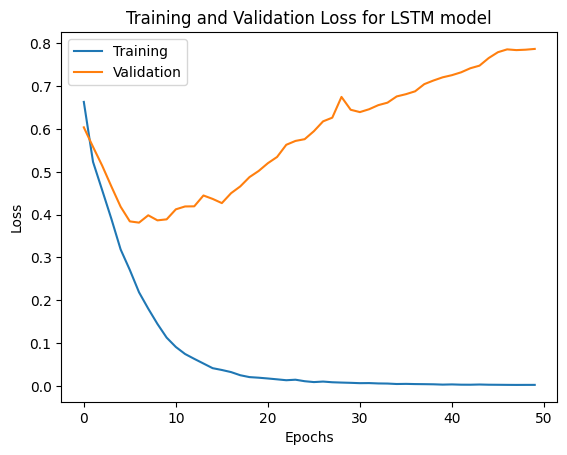

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step

GRU Model:
  ROC AUC Score: 0.86
  Precision: 0.78
  Recall: 0.75
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        23
           1       0.78      0.75      0.76        28

    accuracy                           0.75        51
   macro avg       0.74      0.74      0.74        51
weighted avg       0.75      0.75      0.75        51



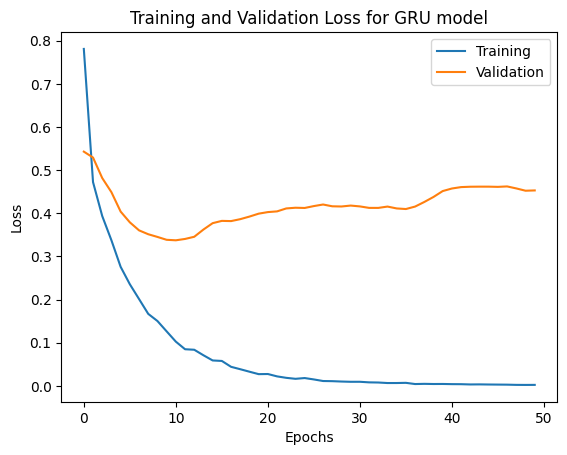

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score, classification_report, precision_score, recall_score
import matplotlib.pyplot as plt

# Prepare data for RNN (LSTM or GRU)
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys).astype(int)  # Ensure y is integer

X = merged_df.drop(['Subject', 'Day', 'Delirium','Diagnosis', 'Steroids','Late_del'], axis=1)
y = merged_df['Diagnosis']

#Scale data as before
numeric_cols = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

TIME_STEPS = 3
X, y = create_sequences(X, y, TIME_STEPS)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

# Define models (LSTM and GRU) using Functional API
def create_lstm_model(input_shape):
    input_layer = keras.Input(shape=input_shape)
    lstm1 = layers.LSTM(64, return_sequences=True)(input_layer)
    lstm2 = layers.LSTM(32)(lstm1)
    dropout = layers.Dropout(0.2)(lstm2)
    output_layer = layers.Dense(1, activation='sigmoid')(dropout)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model

def create_gru_model(input_shape):  # GRU Model Definition
    input_layer = keras.Input(shape=input_shape)
    gru1 = layers.GRU(64, return_sequences=True)(input_layer)  # GRU layer
    gru2 = layers.GRU(32)(gru1)  # GRU layer
    dropout = layers.Dropout(0.2)(gru2)
    output_layer = layers.Dense(1, activation='sigmoid')(dropout)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model

# Train and evaluate models
input_shape = (X_train.shape[1], X_train.shape[2])

models = {
    "LSTM": create_lstm_model(input_shape),
    "GRU": create_gru_model(input_shape) #Include GRU in model dictionary
}

for model_name, model in models.items():
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0) #verbose=0 to suppress training output

    y_pred_proba = model.predict(X_test).flatten()
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, (y_pred_proba > 0.5).astype(int)) #Calculate precision and recall for each model
    recall = recall_score(y_test, (y_pred_proba > 0.5).astype(int))

    print(f"\n{model_name} Model:")
    print(f"  ROC AUC Score: {roc_auc:.2f}")
    print(f"  Precision: {precision:.2f}") #Include precision and recall in output
    print(f"  Recall: {recall:.2f}")
    print(classification_report(y_test, (y_pred_proba > 0.5).astype(int)))

    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for {model_name} model')
    plt.show()